In [52]:
#!pip install xgboost

In [1]:
# CELL 1: Imports + Load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier




In [2]:
# Wczytaj surowy plik (zmień nazwę jeśli inna)
df = pd.read_excel("churn_retail.xlsx")

# Dla czytelności biznesowej zachowamy kopię "oryginalną" (nie skalowaną)
df_orig = df.copy()

print(df_orig.head())
print(df_orig.info())

   CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0       50001      1     4.0         Mobile Phone         3              6.0   
1       50002      1     NaN                Phone         1              8.0   
2       50003      1     NaN                Phone         1             30.0   
3       50004      1     0.0                Phone         3             15.0   
4       50005      1     0.0                Phone         1             12.0   

  PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  ...  \
0           Debit Card  Female             3.0                         3  ...   
1                  UPI    Male             3.0                         4  ...   
2           Debit Card    Male             2.0                         4  ...   
3           Debit Card    Male             2.0                         4  ...   
4                   CC    Male             NaN                         3  ...   

  SatisfactionScore  MaritalStat

In [3]:
# CELL 2: Missing values handling
num_cols = ['Tenure','WarehouseToHome','HourSpendOnApp',
            'OrderAmountHikeFromlastYear','CouponUsed',
            'OrderCount','DaySinceLastOrder','CashbackAmount','NetSales']

for c in num_cols:
    if c in df_orig.columns:
        df_orig[c] = df_orig[c].astype(float).fillna(df_orig[c].median())

# kategorie -> tryb (najczęstsza wartość)
cat_cols = ['PreferredLoginDevice','PreferredPaymentMode','Gender',
            'PreferedOrderCat','MaritalStatus']
for c in cat_cols:
    if c in df_orig.columns:
        df_orig[c] = df_orig[c].fillna(df_orig[c].mode()[0])

# upewnij się, że target jest int
df_orig['Churn'] = df_orig['Churn'].astype(int)

df_orig.isnull().sum()


CustomerID                     0
Churn                          0
Tenure                         0
PreferredLoginDevice           0
CityTier                       0
WarehouseToHome                0
PreferredPaymentMode           0
Gender                         0
HourSpendOnApp                 0
NumberOfDeviceRegistered       0
PreferedOrderCat               0
SatisfactionScore              0
MaritalStatus                  0
NumberOfAddress                0
Complain                       0
OrderAmountHikeFromlastYear    0
CouponUsed                     0
OrderCount                     0
DaySinceLastOrder              0
CashbackAmount                 0
NetSales                       0
dtype: int64

In [4]:
# CELL 3: Encode categoricals
le_dict = {}
for c in cat_cols:
    le = LabelEncoder()
    df_orig[c] = le.fit_transform(df_orig[c])
    le_dict[c] = le


In [5]:
# CELL 4: Scale + Split
features_to_exclude = ['CustomerID','Churn','NetSales']
features_to_scale = [c for c in df_orig.columns if c not in features_to_exclude]

scaler = StandardScaler()
df_scaled = df_orig.copy()
df_scaled[features_to_scale] = scaler.fit_transform(df_scaled[features_to_scale])

X = df_scaled.drop(['CustomerID','Churn'], axis=1)
y = df_scaled['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [6]:
# CELL 5: Baseline XGBoost (możliwy overfitting)
xgb_basic = XGBClassifier(random_state=42, eval_metric='auc')
xgb_basic.fit(X_train, y_train)

# Test
proba_basic_test = xgb_basic.predict_proba(X_test)[:,1]
pred_basic_test  = (proba_basic_test >= 0.5).astype(int)
print("=== XGB Basic — TEST ===")
print(classification_report(y_test, pred_basic_test))
print("ROC-AUC (test):", roc_auc_score(y_test, proba_basic_test))

# Train
proba_basic_train = xgb_basic.predict_proba(X_train)[:,1]
pred_basic_train  = (proba_basic_train >= 0.5).astype(int)
print("\n=== XGB Basic — TRAIN ===")
print(classification_report(y_train, pred_basic_train))
print("ROC-AUC (train):", roc_auc_score(y_train, proba_basic_train))


=== XGB Basic — TEST ===
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       936
           1       0.97      0.93      0.95       190

    accuracy                           0.98      1126
   macro avg       0.98      0.96      0.97      1126
weighted avg       0.98      0.98      0.98      1126

ROC-AUC (test): 0.9984649122807018

=== XGB Basic — TRAIN ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3746
           1       1.00      1.00      1.00       758

    accuracy                           1.00      4504
   macro avg       1.00      1.00      1.00      4504
weighted avg       1.00      1.00      1.00      4504

ROC-AUC (train): 1.0


In [7]:
# CELL 6: Tuned XGBoost (regularization + subsampling)
xgb_tuned = XGBClassifier(
    random_state=42, eval_metric='auc',
    max_depth=4, n_estimators=120,
    reg_alpha=1.0, reg_lambda=2.0,
    subsample=0.8, colsample_bytree=0.8
)
xgb_tuned.fit(X_train, y_train)

# Test
proba_test = xgb_tuned.predict_proba(X_test)[:,1]
pred_test  = (proba_test >= 0.5).astype(int)
print("=== XGB Tuned — TEST ===")
print(classification_report(y_test, pred_test))
print("ROC-AUC (test):", roc_auc_score(y_test, proba_test))

# Train
proba_train = xgb_tuned.predict_proba(X_train)[:,1]
pred_train  = (proba_train >= 0.5).astype(int)
print("\n=== XGB Tuned — TRAIN ===")
print(classification_report(y_train, pred_train))
print("ROC-AUC (train):", roc_auc_score(y_train, proba_train))


=== XGB Tuned — TEST ===
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       936
           1       0.89      0.79      0.84       190

    accuracy                           0.95      1126
   macro avg       0.92      0.88      0.90      1126
weighted avg       0.95      0.95      0.95      1126

ROC-AUC (test): 0.986240440845704

=== XGB Tuned — TRAIN ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3746
           1       0.98      0.95      0.96       758

    accuracy                           0.99      4504
   macro avg       0.99      0.97      0.98      4504
weighted avg       0.99      0.99      0.99      4504

ROC-AUC (train): 0.9989057809420637


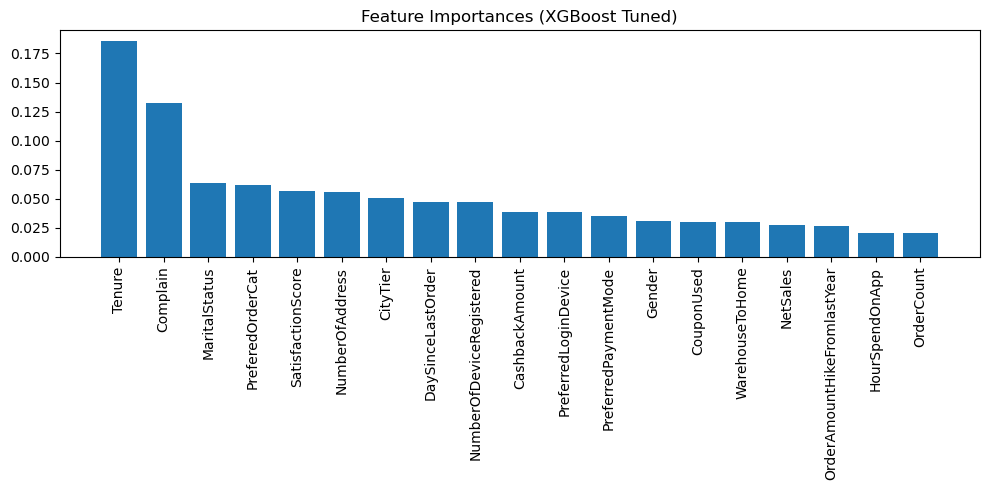

In [8]:
# CELL 7: Feature importance (top)
import matplotlib.pyplot as plt
import numpy as np

importances = xgb_tuned.feature_importances_
idx = np.argsort(importances)[::-1]
names = X_train.columns[idx]

plt.figure(figsize=(10,5))
plt.bar(range(len(importances)), importances[idx])
plt.xticks(range(len(importances)), names, rotation=90)
plt.title("Feature Importances (XGBoost Tuned)")
plt.tight_layout()
plt.show()


In [9]:
# CELL 8: Preview predictions on TEST
X_test_pred = X_test.copy()
X_test_pred['CustomerID'] = df_scaled.loc[X_test.index, 'CustomerID'].values
X_test_pred['NetSales']   = df_orig.loc[X_test.index, 'NetSales'].values
X_test_pred['churn_proba'] = proba_test

def segment_risk(p):
    if p >= 0.70: return 'high'
    if p >= 0.40: return 'medium'
    return 'low'

X_test_pred['churn_risk'] = X_test_pred['churn_proba'].apply(segment_risk)
X_test_pred.head()


,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,...,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,NetSales,CustomerID,churn_proba,churn_risk
4006,0.821554,-1.308078,1.469771,-0.786892,0.325191,0.814685,1.510158,0.30375,-0.261904,-1.497592,...,-0.631198,1.483093,2.305887,1.749983,0.991700,0.092007,1680.0,54007,0.001634,low
1969,1.898468,0.100852,1.469771,-0.307575,1.044856,-1.227468,0.092654,0.30375,-1.679027,-1.497592,...,1.584290,0.647610,-0.924305,-0.681423,-0.408739,0.652749,292.0,51970,0.000296,low
4235,-0.614332,0.100852,-0.715286,-0.067917,0.325191,-1.227468,1.510158,0.30375,-0.261904,-1.497592,...,-0.631198,2.318576,0.152425,-0.334079,1.271788,-0.162248,668.0,54236,0.001013,low
105,1.778811,1.509782,-0.715286,-0.906721,0.325191,-1.227468,-1.324850,0.30375,0.446658,-0.772992,...,-0.631198,-0.187872,-0.924305,-0.334079,-0.688827,-0.916679,394.0,50106,0.001050,low
2295,-0.733989,-1.308078,1.469771,-0.906721,0.325191,-1.227468,-1.324850,-0.67290,-1.679027,-0.048392,...,1.584290,0.926105,3.382617,2.097327,0.431524,0.432842,2223.0,52296,0.238827,low


In [10]:
# CELL 9: Predictions for ALL customers (pełny eksport bazowy)
proba_all = xgb_tuned.predict_proba(X)[:,1]

export_df = df_orig.copy()       # czytelne kolumny
export_df['churn_proba'] = proba_all
export_df['churn_risk']  = export_df['churn_proba'].apply(segment_risk)

# Rekomendacje + koszty kampanii + ROI (realne, edytowalne)
EMAIL_COST = 2.0
PHONE_COST = 20.0
DISCOUNT_HIGH_PCT = 0.10
DISCOUNT_MED_PCT  = 0.05
RETENTION_RATE = {'high': 0.30, 'medium': 0.15, 'low': 0.00}

def discount_pct(seg):
    return {'high': DISCOUNT_HIGH_PCT, 'medium': DISCOUNT_MED_PCT, 'low': 0.0}.get(seg, 0.0)

def recommend_action(seg):
    return ('Kontakt telefoniczny + oferta rabatowa' if seg=='high'
            else 'E-mail z ofertą specjalną' if seg=='medium'
            else 'Brak akcji (monitoring)')

def fixed_cost(action):
    a = action.lower()
    if 'telefon' in a: return PHONE_COST
    if 'e-mail' in a or 'email' in a: return EMAIL_COST
    return 0.0

export_df['rekomendacja']  = export_df['churn_risk'].apply(recommend_action)
export_df['retention_rate'] = export_df['churn_risk'].map(RETENTION_RATE).astype(float)
export_df['discount_pct']   = export_df['churn_risk'].map(discount_pct).astype(float)
export_df['Koszt_kampanii'] = export_df.apply(
    lambda r: fixed_cost(r['rekomendacja']) + (r['NetSales'] * r['discount_pct']),
    axis=1
)
export_df['NetSales_if_retained']   = export_df['NetSales'] * export_df['retention_rate']
export_df['Zysk_netto_po_kampanii'] = export_df['NetSales_if_retained'] - export_df['Koszt_kampanii']
export_df['ROI'] = export_df.apply(
    lambda r: (r['Zysk_netto_po_kampanii']/r['Koszt_kampanii']) if r['Koszt_kampanii']>0 else np.nan, axis=1
)

export_df.head(3)


,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,...,NetSales,churn_proba,churn_risk,rekomendacja,retention_rate,discount_pct,Koszt_kampanii,NetSales_if_retained,Zysk_netto_po_kampanii,ROI
0,50001,1,4.0,1,3,6.0,4,0,3.0,3,...,252.0,0.730946,high,Kontakt telefoniczny + oferta rabatowa,0.3,0.1,45.2,75.6,30.4,0.672566
1,50002,1,9.0,2,1,8.0,6,1,3.0,4,...,329.0,0.965723,high,Kontakt telefoniczny + oferta rabatowa,0.3,0.1,52.9,98.7,45.8,0.865784
2,50003,1,9.0,2,1,30.0,4,1,2.0,4,...,242.0,0.969323,high,Kontakt telefoniczny + oferta rabatowa,0.3,0.1,44.2,72.6,28.4,0.642534


In [11]:
# CELL 10: Segment summary
summary_by_segment = export_df.groupby('churn_risk').agg(
    Klientow=('CustomerID','count'),
    NetSales_sum=('NetSales','sum'),
    Srednia_proba=('churn_proba','mean'),
    Koszt_kampanii_sum=('Koszt_kampanii','sum'),
    Uratowany_przychod_sum=('NetSales_if_retained','sum'),
    Zysk_netto_sum=('Zysk_netto_po_kampanii','sum')
).reindex(['low','medium','high'])

summary_by_segment['ROI'] = summary_by_segment['Zysk_netto_sum'] / summary_by_segment['Koszt_kampanii_sum'].replace({0:np.nan})
summary_by_segment


,Klientow,NetSales_sum,Srednia_proba,Koszt_kampanii_sum,Uratowany_przychod_sum,Zysk_netto_sum,ROI
churn_risk,,,,,,,
low,4670,3791181.0,0.032593,0.00,0.00,0.0,NaN
medium,193,110987.0,0.562859,5935.35,16648.05,10712.7,1.804898
high,767,600565.0,0.886518,75396.50,180169.50,104773.0,1.389627


In [12]:
# CELL 11: Excel export (All customers FIRST sheet)
front_cols = [
    'CustomerID','Churn','churn_proba','churn_risk','rekomendacja',
    'NetSales','retention_rate','discount_pct','Koszt_kampanii',
    'NetSales_if_retained','Zysk_netto_po_kampanii','ROI'
]
other_cols = [c for c in export_df.columns if c not in front_cols]

all_customers = export_df[front_cols + other_cols].sort_values('churn_proba', ascending=False)
at_risk = all_customers[all_customers['churn_risk'].isin(['medium','high'])].copy()
summary_reset = summary_by_segment.reset_index().rename(columns={'index':'churn_risk'})

out_file = "Churn_Analysis_Full_Export.xlsx"
with pd.ExcelWriter(out_file) as writer:
    all_customers.to_excel(writer, sheet_name='All_Customers', index=False)   # 1. pełna lista z proba
    at_risk.to_excel(writer, sheet_name='At_Risk_Customers', index=False)     # 2. zagrożeni
    summary_reset.to_excel(writer, sheet_name='Summary_by_Segment', index=False) # 3. podsumowanie

print(f"✅ Zapisano: {out_file}")


✅ Zapisano: Churn_Analysis_Full_Export.xlsx


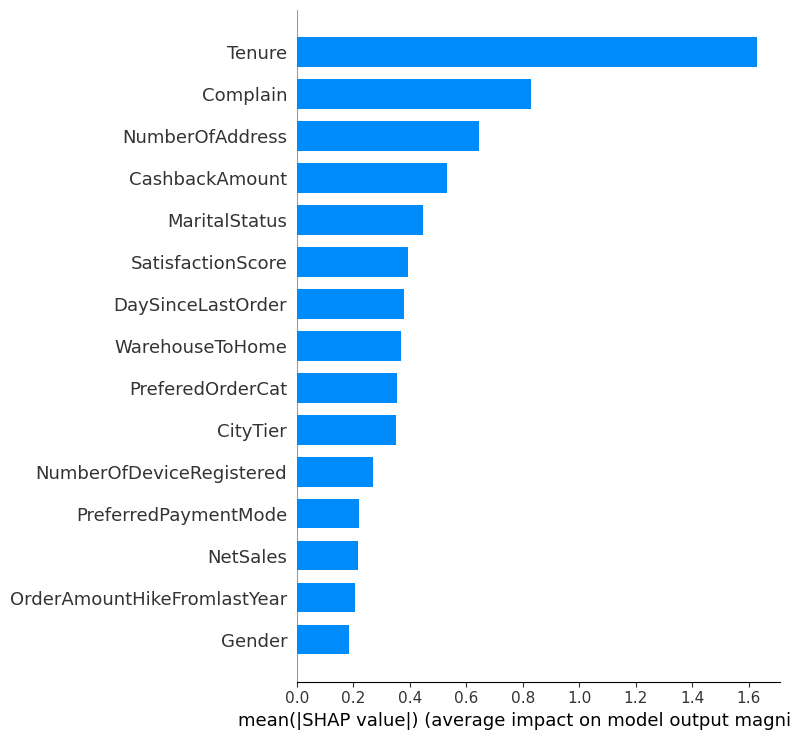

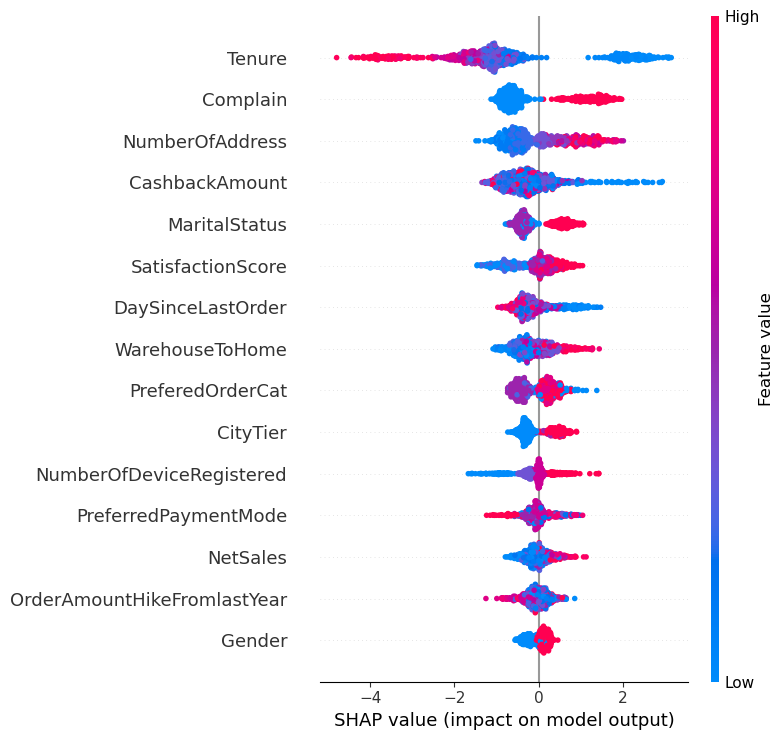

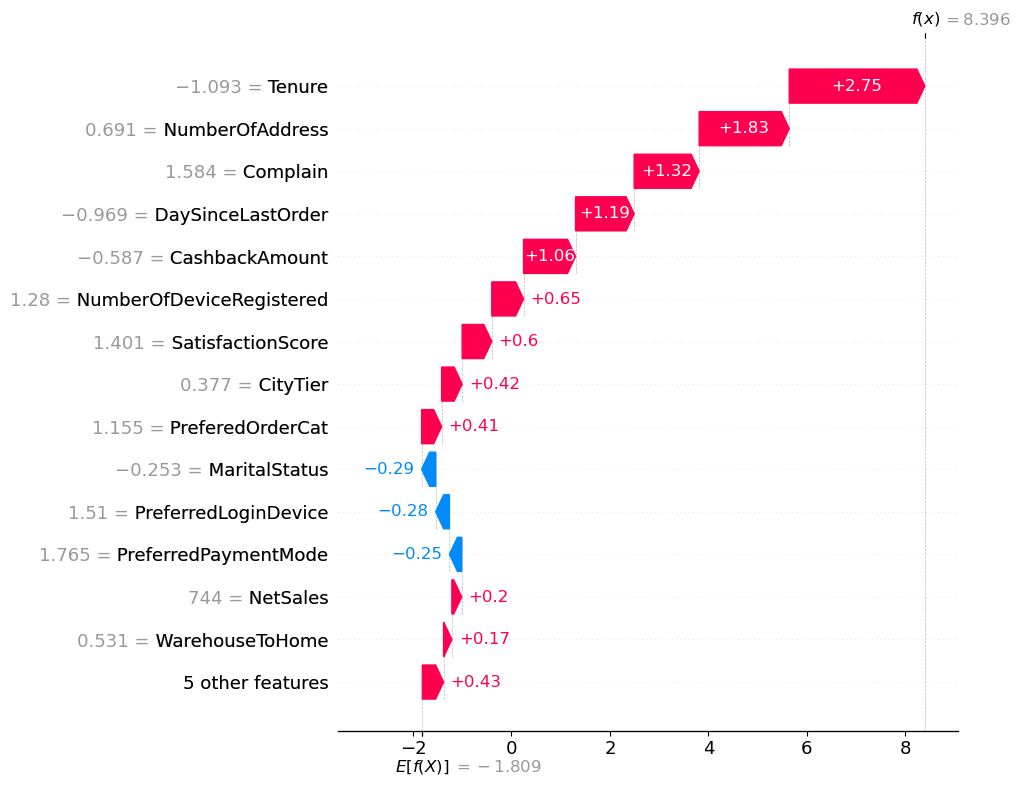

In [13]:
# CELL 12: SHAP (optional)
# !pip install shap --quiet
import shap

feat_names = X_train.columns
explainer = shap.TreeExplainer(xgb_tuned)
# mała próbka dla szybkości
sample_idx = np.random.default_rng(42).choice(X_test.index, size=min(800, len(X_test)), replace=False)
shap_vals = explainer.shap_values(X_test.loc[sample_idx, feat_names])

shap.summary_plot(shap_vals, X_test.loc[sample_idx, feat_names], plot_type='bar', max_display=15)
shap.summary_plot(shap_vals, X_test.loc[sample_idx, feat_names], max_display=15)

# jeden klient (najwyższe ryzyko z całej bazy)
top_id = all_customers.iloc[0]['CustomerID']
row_idx = df_scaled[df_scaled['CustomerID']==top_id].index[0]
single = explainer(X.loc[row_idx:row_idx, feat_names])
try:
    shap.plots.waterfall(single[0], max_display=15)
except Exception:
    shap.initjs()
    display(shap.force_plot(explainer.expected_value, single.values[0], X.loc[row_idx, feat_names], matplotlib=True))


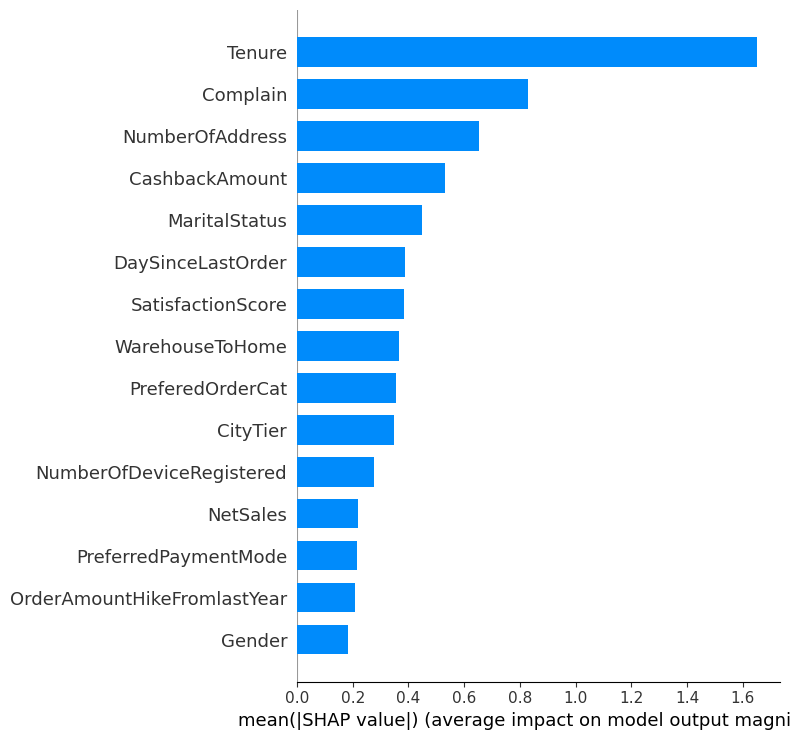

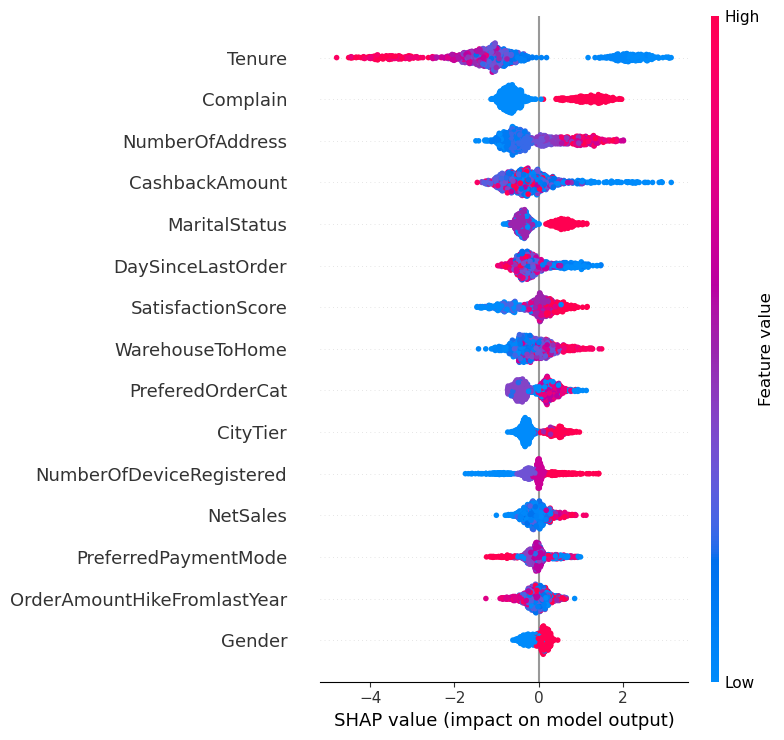

In [14]:
# === CELL 13: SHAP — global explanations ===
# Jeśli shap nie jest zainstalowany, odkomentuj:
# !pip install shap --quiet

import shap
import numpy as np

# Upewnij się, że używamy dokładnie tych kolumn, na których trenowaliśmy model
feat_names = X_train.columns
X_test_shap = X_test[feat_names].copy()

# Użyj finalnego modelu po tuningu (np. xgb_tuned)
explainer = shap.TreeExplainer(xgb_tuned)

# (Opcjonalnie) próbkuj, by przyspieszyć wykresy
sample_idx = np.random.default_rng(42).choice(X_test_shap.index, size=min(1000, len(X_test_shap)), replace=False)
X_sample = X_test_shap.loc[sample_idx]

# Oblicz wartości SHAP
shap_values = explainer.shap_values(X_sample)

# Wykres słupkowy (średnie absolutne SHAP)
shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=15)

# Wykres „beeswarm”
shap.summary_plot(shap_values, X_sample, max_display=15)


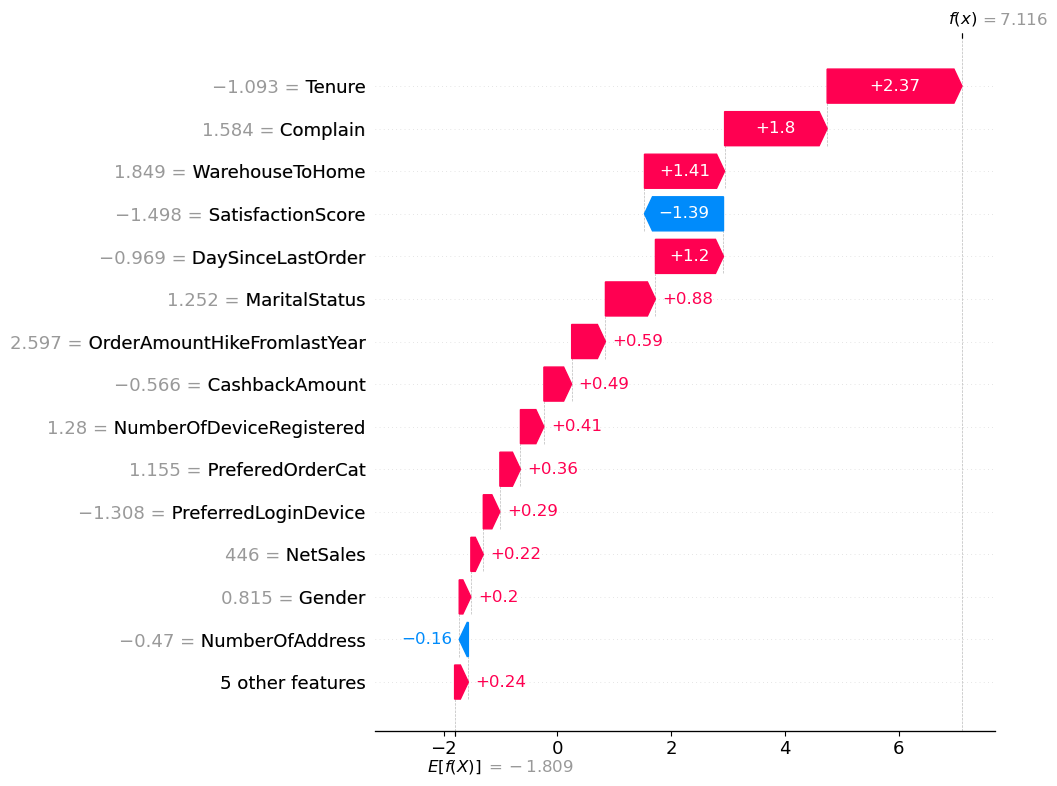

In [15]:
# === CELL 14: SHAP — local explanation for a single customer ===
top_customer_id = X_test_pred.sort_values('churn_proba', ascending=False).iloc[0]['CustomerID']
row_idx = X_test_pred[X_test_pred['CustomerID'] == top_customer_id].index[0]

row_for_model = X_test_shap.loc[row_idx:row_idx]

shap_single = explainer(row_for_model)

try:
    shap.plots.waterfall(shap_single[0], max_display=15)
except Exception:
    shap.initjs()
    display(shap.force_plot(explainer.expected_value, shap_single.values[0], row_for_model.iloc[0], matplotlib=True))


In [17]:
# === CELL 16: Export feature importance SHAP to Excel (ładnie sformatowane) ===
import pandas as pd
from openpyxl import load_workbook
from openpyxl.styles import Font
from openpyxl.utils import get_column_letter

# upewnij się, że fi_shap nie jest puste
if not fi_shap.empty:
    out_file = "Feature_Importance_SHAP.xlsx"
    fi_shap_out = fi_shap[['feature','feature_friendly','importance_pct']]

    # zapisz do Excela
    fi_shap_out.to_excel(out_file, sheet_name="SHAP_Importance", index=False)

    # otwórz plik i sformatuj
    wb = load_workbook(out_file)
    ws = wb.active

    # pogrubienie nagłówków
    for cell in ws[1]:
        cell.font = Font(bold=True)

    # auto-fit szerokości kolumn
    for col in ws.columns:
        max_len = 0
        col_letter = get_column_letter(col[0].column)
        for cell in col:
            try:
                val = str(cell.value)
                if len(val) > max_len:
                    max_len = len(val)
            except:
                pass
        ws.column_dimensions[col_letter].width = max_len + 2

    wb.save(out_file)
    print(f"✅ Zapisano: {out_file}")
else:
    print("⚠️ fi_shap jest puste, brak danych do eksportu.")


✅ Zapisano: Feature_Importance_SHAP.xlsx
